In [7]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
import time
import argparse
from models import NEGA
from utils import save_model, load_model, generate_graphs_and_states
from torch_geometric.utils.convert import to_networkx


args = argparse.Namespace(  graph_type='erdos_renyi', 
                            input_dim=1,
                            hidden_dim=32, 
                            lr=0.0005,
                            layers=1,
                            epochs=50, 
                            n_samples_train=100,
                            n_nodes_train=20,
                            n_samples_val=5, 
                            n_nodes_val=20,
                            n_samples_test=5,
                            n_nodes_test=100, 
                          )

Reachability:  tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
         1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
         1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]])


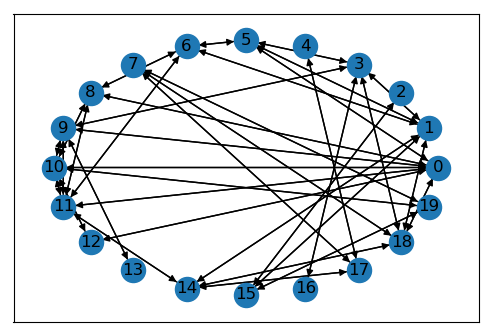

In [8]:
train_graphs, train_states = generate_graphs_and_states(args.n_samples_train, args.n_nodes_train ,args.graph_type)
val_graphs, val_states = generate_graphs_and_states(args.n_samples_val, args.n_nodes_val ,args.graph_type)
graph = to_networkx(train_graphs[0])
plt.figure(figsize=(6,4))
pos=nx.circular_layout(graph)
print("Reachability: ", train_states[0])
nx.draw_networkx(graph,pos=pos)

In [9]:
if torch.cuda.is_available():
    print('use gpu')
    device = torch.device("cuda")
else:
    print('use cpu')
    device = torch.device("cpu")

model = NEGA(args.input_dim, args.hidden_dim, args.layers).to(device)
print(model)

use gpu
NEGA(
  (encoder): Encoder(
    (w): Linear(in_features=33, out_features=32, bias=True)
  )
  (processor_net): GAT(
    (relu): ReLU()
    (GATConv): ModuleList(
      (0): GATConv(32, 32, heads=1)
    )
  )
  (decoder): Decoder(
    (w): Linear(in_features=64, out_features=32, bias=True)
    (w1): Linear(in_features=32, out_features=32, bias=True)
    (bs): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (head): Linear(in_features=32, out_features=1, bias=True)
    (sig): Sigmoid()
  )
  (termination_net): Termination(
    (w): Linear(in_features=32, out_features=1, bias=True)
    (sig): Sigmoid()
  )
)


In [10]:
optimizer = optim.Adam(model.parameters(), lr=args.lr)
schedualr = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
criteria = nn.BCELoss()

best_model = None
best_accu = 0
# PATH='./best_model.pt'
patience = 0
MAX_PATIENCE=15


for i in range(args.epochs):
    t_losses = []
    model.train()
    for graph, states in zip(train_graphs,train_states):
        x, edge_index = graph.x.to(device), graph.edge_index.to(device)
        states = states.to(device)
        N = x.shape[0]
        h = torch.zeros(N, args.hidden_dim).to(device)
        num_nodes = len(x)
        x=x.unsqueeze(dim=1)
        losses = []
        for j in range(num_nodes):
            optimizer.zero_grad()
            out,t, h = model(x, h, edge_index)
            stop = 0
            if len(states) - 1 == j:
                stop = 1
            x = (out > .5).to(int)
            target= states[j]
            out = out.squeeze(1)
            classification_loss = criteria(out,target)
            termination_target = torch.tensor(stop).to(device).unsqueeze(0)
            
            termination_loss = criteria(t,termination_target.float())
            
            loss = classification_loss + termination_loss
        
            loss.backward()
            
            optimizer.step()
            schedualr.step()
            h = h.detach()
            x = x.detach()
            losses.append(loss.item())
            if stop ==1:
                break
        mean_loss = np.mean(losses)
        t_losses.append(mean_loss)


    all_accu = []

    last = []
    model.eval()
    with torch.no_grad():
        for graph, states in zip(val_graphs, val_states):
            x, edge_index = graph.x.to(device), graph.edge_index.to(device)
            states = states.to(device)
            N = x.shape[0]
            h = torch.zeros(N, args.hidden_dim).to(device)
            v = len(x)
            x=x.unsqueeze(dim=1)
            accus = []
            for k in range(v):
                out,t, h = model(x, h, edge_index)
                stop = 0
                if len(states)-1 == k:
                    stop = 1
                x = ( out > .5).to(int)
                target= states[k]
                out =( out > .5).to(int)
                out = out.squeeze(1)
                accu = torch.sum(out == target) / len(out)
                accus.append(accu.item())
                if stop ==1:
                    break
            accu = np.mean(accus)
            all_accu.append(accu)
            last.append(accus[-1])
    average_accu=np.mean(all_accu)
    last_accu = np.mean(last)

    
    loss = np.mean(t_losses)


    print(f"Epoch {i+1} | loss (Training) {loss:.2f} | Average Accuracy (Val) {average_accu*100:.2f} | Last Accuracy (Val) {last_accu*100:.2f} | Best {best_accu*100:.2f}")
    if best_accu < average_accu:
        patience=0
        model_name = 'model.pt'
        save_model(model,model_name)
        best_accu = average_accu
    else:
        patience +=1
        if patience == MAX_PATIENCE:
            break

Epoch 1 | Train loss 1.10 | Val accuracy 71.35/99.00 | Best 0.00
Epoch 2 | Train loss 0.74 | Val accuracy 85.85/99.00 | Best 71.35
Epoch 3 | Train loss 0.65 | Val accuracy 85.85/99.00 | Best 85.85
Epoch 4 | Train loss 0.63 | Val accuracy 85.85/99.00 | Best 85.85
Epoch 5 | Train loss 0.63 | Val accuracy 85.85/99.00 | Best 85.85
Epoch 6 | Train loss 0.63 | Val accuracy 85.85/99.00 | Best 85.85
Epoch 7 | Train loss 0.62 | Val accuracy 85.85/99.00 | Best 85.85
Epoch 8 | Train loss 0.62 | Val accuracy 85.85/99.00 | Best 85.85
Epoch 9 | Train loss 0.61 | Val accuracy 85.85/99.00 | Best 85.85
Epoch 10 | Train loss 0.61 | Val accuracy 85.85/99.00 | Best 85.85
Epoch 11 | Train loss 0.60 | Val accuracy 85.85/99.00 | Best 85.85
Epoch 12 | Train loss 0.58 | Val accuracy 85.85/99.00 | Best 85.85
Epoch 13 | Train loss 0.58 | Val accuracy 89.35/99.00 | Best 85.85
Epoch 14 | Train loss 0.46 | Val accuracy 92.55/100.00 | Best 89.35
Epoch 15 | Train loss 0.38 | Val accuracy 93.40/100.00 | Best 92.55
Epo

In [11]:
model_path = './checkpoints/model.pt'
model = load_model(model,model_path)
test_graphs, test_states = generate_graphs_and_states(10, 300 , 'erdos_renyi')
t_accus = []
model.eval()
for graph_no, (graph, states) in enumerate(zip(test_graphs,test_states)):
    x, edge_index = graph.x.to(device), graph.edge_index.to(device)
    states = states.to(device)
    N = x.shape[0]
    h = torch.zeros(N, args.hidden_dim).to(device)
    v = len(x)
    x=x.unsqueeze(dim=1)
    accus = []
    for i in range(v):
        out,t, h = model(x, h, edge_index)
        stop = 0
        if len(states)-1 == i:
            stop = 1
        x = (out > .5).to(int)
        target= states[i]
        out =( out > .5).to(int)
        out = out.squeeze(1)
        accu = torch.sum(out == target) / len(out)
        accus.append(accu.item())

        
        if stop ==1:
            break
        if t.item() > .5:
                break

    a = np.mean(accus)
    l = accus[-1]
    print(f'Graph {graph_no} | Average Accuracy {a:.2f} | Last Accuracy {l:.2f}')
    t_accus.append(a)

        

all_a = np.mean(t_accus)
print(f'Average Accuracy Across All Graphs {all_a:.2f}')
# np.mean(t_accus), t_accus[-1]

Graph 0 | Average Accuracy 0.97 | Last Accuracy 1.00
Graph 1 | Average Accuracy 0.94 | Last Accuracy 1.00
Graph 2 | Average Accuracy 0.92 | Last Accuracy 1.00
Graph 3 | Average Accuracy 0.95 | Last Accuracy 1.00
Graph 4 | Average Accuracy 0.97 | Last Accuracy 1.00
Graph 5 | Average Accuracy 0.95 | Last Accuracy 1.00
Graph 6 | Average Accuracy 0.93 | Last Accuracy 1.00
Graph 7 | Average Accuracy 0.95 | Last Accuracy 1.00
Graph 8 | Average Accuracy 0.95 | Last Accuracy 1.00
Graph 9 | Average Accuracy 0.96 | Last Accuracy 1.00
Average Accuracy Across All Graphs 0.95
